In [26]:
import os
from glob import glob

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical # convert to one-hot-encoding

from keras.preprocessing.image import ImageDataGenerator
from keras import layers
from keras import Model
from keras.applications.inception_v3 import InceptionV3, preprocess_input
from keras.optimizers.legacy import Adam
from keras.callbacks import ReduceLROnPlateau, EarlyStopping
from keras import backend as K

%matplotlib inline
import matplotlib.pyplot as plt

In [27]:
X_train = np.load("/kaggle/input/npyfiles/npy/256_192_train.npy")

In [28]:
y_train = np.load("/kaggle/input/npyfiles/npy/train_labels.npy")

In [29]:
X_val = np.load("/kaggle/input/npyfiles/npy/256_192_val.npy")

In [30]:
y_val = np.load("/kaggle/input/npyfiles/npy/val_labels.npy")

In [31]:
X_train.shape, X_val.shape

((8111, 192, 256, 3), (902, 192, 256, 3))

In [32]:
y_train.shape, y_val.shape

((8111,), (902,))

In [33]:
y_train = to_categorical(y_train)
y_val = to_categorical(y_val)

In [34]:
pre_trained_model = InceptionV3(input_shape=(192, 256, 3), include_top=False, weights="imagenet")

In [35]:
for layer in pre_trained_model.layers:
    print(layer.name)
    if hasattr(layer, 'moving_mean') and hasattr(layer, 'moving_variance'):
        layer.trainable = True
        K.eval(K.update(layer.moving_mean, K.zeros_like(layer.moving_mean)))
        K.eval(K.update(layer.moving_variance, K.zeros_like(layer.moving_variance)))
    else:
        layer.trainable = False

print(len(pre_trained_model.layers))

input_3
conv2d_188
batch_normalization_188
activation_188
conv2d_189
batch_normalization_189
activation_189
conv2d_190
batch_normalization_190
activation_190
max_pooling2d_8
conv2d_191
batch_normalization_191
activation_191
conv2d_192
batch_normalization_192
activation_192
max_pooling2d_9
conv2d_196
batch_normalization_196
activation_196
conv2d_194
conv2d_197
batch_normalization_194
batch_normalization_197
activation_194
activation_197
average_pooling2d_18
conv2d_193
conv2d_195
conv2d_198
conv2d_199
batch_normalization_193
batch_normalization_195
batch_normalization_198
batch_normalization_199
activation_193
activation_195
activation_198
activation_199
mixed0
conv2d_203
batch_normalization_203
activation_203
conv2d_201
conv2d_204
batch_normalization_201
batch_normalization_204
activation_201
activation_204
average_pooling2d_19
conv2d_200
conv2d_202
conv2d_205
conv2d_206
batch_normalization_200
batch_normalization_202
batch_normalization_205
batch_normalization_206
activation_200
activa

In [36]:
last_layer = pre_trained_model.get_layer('mixed10')
print('last layer output shape:', last_layer.output_shape)
last_output = last_layer.output

last layer output shape: (None, 4, 6, 2048)


In [37]:
# Flatten the output layer to 1 dimension
x = layers.GlobalMaxPooling2D()(last_output)
# Add a fully connected layer with 512 hidden units and ReLU activation
x = layers.Dense(512, activation='relu')(x)
# Add a dropout rate of 0.5
x = layers.Dropout(0.5)(x)
# Add a final sigmoid layer for classification
x = layers.Dense(7, activation='softmax')(x)

# Configure and compile the model

model = Model(pre_trained_model.input, x)
optimizer = Adam(lr=0.0001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=True)
model.compile(loss='categorical_crossentropy',
              optimizer=optimizer,
              metrics=['accuracy'])

/opt/conda/lib/python3.10/site-packages/keras/src/optimizers/legacy/adam.py:118: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


In [38]:
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_3 (InputLayer)        [(None, 192, 256, 3)]        0         []                            
                                                                                                  
 conv2d_188 (Conv2D)         (None, 95, 127, 32)          864       ['input_3[0][0]']             
                                                                                                  
 batch_normalization_188 (B  (None, 95, 127, 32)          96        ['conv2d_188[0][0]']          
 atchNormalization)                                                                               
                                                                                                  
 activation_188 (Activation  (None, 95, 127, 32)          0         ['batch_normalization_18

In [39]:
train_datagen = ImageDataGenerator(rotation_range=60, width_shift_range=0.2, height_shift_range=0.2,
                                   shear_range=0.2, zoom_range=0.2, fill_mode='nearest')

train_datagen.fit(X_train)

val_datagen = ImageDataGenerator()
val_datagen.fit(X_val)

In [40]:
batch_size = 64
epochs = 3
history = model.fit_generator(train_datagen.flow(X_train,y_train, batch_size=batch_size),
                              epochs = epochs, validation_data = val_datagen.flow(X_val, y_val),
                              verbose = 1, steps_per_epoch=(X_train.shape[0] // batch_size), 
                              validation_steps=(X_val.shape[0] // batch_size))

/tmp/ipykernel_27/3971016608.py:3: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(train_datagen.flow(X_train,y_train, batch_size=batch_size),


Epoch 1/3
126/126 [==============================] - 107s 747ms/step - loss: 1.5364 - accuracy: 0.5965 - val_loss: 1.6188 - val_accuracy: 0.6652
Epoch 2/3
126/126 [==============================] - 90s 712ms/step - loss: 1.0938 - accuracy: 0.6637 - val_loss: 0.9811 - val_accuracy: 0.6942
Epoch 3/3
126/126 [==============================] - 90s 712ms/step - loss: 1.0427 - accuracy: 0.6677 - val_loss: 0.9178 - val_accuracy: 0.6987


In [41]:
for layer in pre_trained_model.layers[249:]:
    layer.trainable = True

In [42]:
optimizer = Adam(lr=0.0001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
model.compile(loss='categorical_crossentropy',
              optimizer=optimizer,
              metrics=['acc'])

In [43]:
learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc', patience=3, verbose=1, factor=0.5, 
                                            min_lr=0.000001, cooldown=2)

In [44]:
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_3 (InputLayer)        [(None, 192, 256, 3)]        0         []                            
                                                                                                  
 conv2d_188 (Conv2D)         (None, 95, 127, 32)          864       ['input_3[0][0]']             
                                                                                                  
 batch_normalization_188 (B  (None, 95, 127, 32)          96        ['conv2d_188[0][0]']          
 atchNormalization)                                                                               
                                                                                                  
 activation_188 (Activation  (None, 95, 127, 32)          0         ['batch_normalization_18

In [45]:
batch_size = 64
epochs = 35
history = model.fit_generator(train_datagen.flow(X_train,y_train, batch_size=batch_size),
                              epochs = epochs, validation_data = val_datagen.flow(X_val, y_val),
                              verbose = 1, steps_per_epoch=(X_train.shape[0] // batch_size),
                              validation_steps=(X_val.shape[0] // batch_size),
                              callbacks=[learning_rate_reduction])

/tmp/ipykernel_27/1245916579.py:3: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(train_datagen.flow(X_train,y_train, batch_size=batch_size),


Epoch 1/35
126/126 [==============================] - 98s 717ms/step - loss: 0.9188 - acc: 0.6943 - val_loss: 0.9194 - val_acc: 0.6696 - lr: 1.0000e-04
Epoch 2/35
126/126 [==============================] - 90s 711ms/step - loss: 0.8062 - acc: 0.7139 - val_loss: 0.7483 - val_acc: 0.7455 - lr: 1.0000e-04
Epoch 3/35
126/126 [==============================] - 89s 705ms/step - loss: 0.7386 - acc: 0.7423 - val_loss: 0.8726 - val_acc: 0.6942 - lr: 1.0000e-04
Epoch 4/35
126/126 [==============================] - 90s 712ms/step - loss: 0.6919 - acc: 0.7571 - val_loss: 0.7916 - val_acc: 0.7232 - lr: 1.0000e-04
Epoch 5/35
126/126 [==============================] - 89s 700ms/step - loss: 0.6405 - acc: 0.7629 - val_loss: 0.6861 - val_acc: 0.7522 - lr: 1.0000e-04
Epoch 6/35
126/126 [==============================] - 91s 722ms/step - loss: 0.6236 - acc: 0.7777 - val_loss: 0.6848 - val_acc: 0.7612 - lr: 1.0000e-04
Epoch 7/35
126/126 [==============================] - 90s 712ms/step - loss: 0.5904 - ac

In [46]:
loss_val, acc_val = model.evaluate(X_val, y_val, verbose=1)
print("Validation: accuracy = %f  ;  loss_v = %f" % (acc_val, loss_val))

29/29 [==============================] - 3s 99ms/step - loss: 0.6673 - acc: 0.8115
Validation: accuracy = 0.811530  ;  loss_v = 0.667329


In [47]:
X_test = np.load("/kaggle/input/npyfiles/npy/256_192_test.npy")

In [48]:
y_test = np.load("/kaggle/input/npyfiles/npy/test_labels.npy")
y_test = to_categorical(y_test)

In [49]:
loss_test, acc_test = model.evaluate(X_test, y_test, verbose=1)
print("Test: accuracy = %f  ;  loss = %f" % (acc_test, loss_test))

32/32 [==============================] - 3s 99ms/step - loss: 0.7514 - acc: 0.8044
Test: accuracy = 0.804391  ;  loss = 0.751360


In [50]:
model.save("InceptionV3FT.h5")

/opt/conda/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Text(0.5, 1.0, 'Training and validation loss')

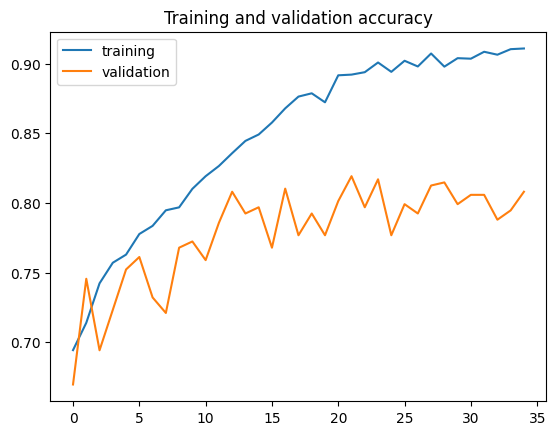

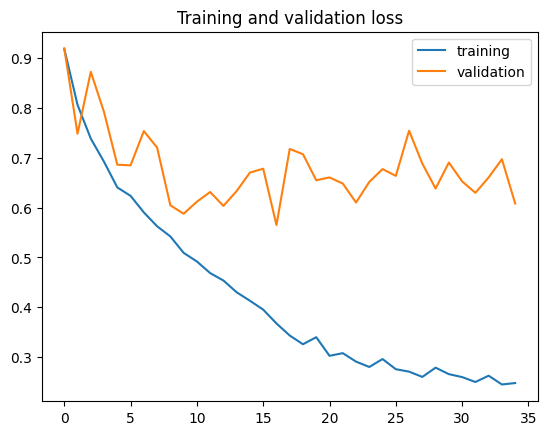

In [51]:
# Retrieve a list of accuracy results on training and test data
# sets for each training epoch
acc = history.history['acc']
val_acc = history.history['val_acc']

# Retrieve a list of list results on training and test data
# sets for each training epoch
loss = history.history['loss']
val_loss = history.history['val_loss']

# Get number of epochs
epochs = range(len(acc))

# Plot training and validation accuracy per epoch
plt.plot(epochs, acc, label = "training")
plt.plot(epochs, val_acc, label = "validation")
plt.legend(loc="upper left")
plt.title('Training and validation accuracy')

plt.figure()

# Plot training and validation loss per epoch
plt.plot(epochs, loss, label = "training")
plt.plot(epochs, val_loss, label = "validation")
plt.legend(loc="upper right")
plt.title('Training and validation loss')